# Training a neural network model on the Wikidata dataset

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

---

## Load the data

In [2]:
root_dir = '../../'
src_dir = 'src'
data_dir = 'data/corpus'
models_dir = 'data/models'

In [ ]:
version = 'v1'

In [3]:
import os
import sys

In [4]:
sys.path.append(os.path.join(root_dir, src_dir))

In [5]:
corpus_filename = f'wikidata_corpus_{version}.json'

In [6]:
from training import TrainingCorpus

In [7]:
corpus = TrainingCorpus()
corpus.load(os.path.join(root_dir, data_dir, corpus_filename))

In [8]:
corpus.size

120

---

## Load the Glove model

In [9]:
from gensim.models import KeyedVectors

unable to import 'smart_open.gcs', disabling that module


In [10]:
glove_filename = 'glove.6B.200d.word2vec'

In [11]:
glove_model = KeyedVectors.load_word2vec_format(os.path.join(root_dir, models_dir, glove_filename), binary=False)

---

## Split the dataset into training and test set

In [12]:
train_doc_ids, test_doc_ids, train_labels, test_labels = corpus.get_train_test_data(test_size=0.2, random_state=3)

In [13]:
n_classes = train_labels.shape[1]
print(f'Training set size: {len(train_doc_ids)}')
print(f'Test set size: {len(test_doc_ids)}')
print(f'No. of labels: {n_classes}')

Training set size: 96
Test set size: 24
No. of labels: 6


---

## Build the embedding matrix

### Define the vocabulary

In [14]:
docs_tokens = [corpus.get_tokens(doc_id) for doc_id in train_doc_ids]
vocab = sorted({token for tokens in docs_tokens for token in tokens})

In [15]:
vocab[:5]

['+23', '+8', '1', '1,439', '10,051']

In [16]:
print(f'There are {len(vocab)} unique words in the training set')

There are 239 unique words in the training set


### Encode vocabulary terms as integers

In [17]:
# +1 as index 0 is reserved
word_to_idx_map = {word:idx+1 for idx, word in enumerate(vocab)}

### Define the embedding matrix

In [18]:
import numpy as np

In [19]:
embedding_size = glove_model.vector_size
embedding_size

200

In [20]:
embedding_matrix = np.zeros((len(word_to_idx_map) + 1, embedding_size))
embedding_matrix.shape

(240, 200)

In [21]:
embedding_found_count = 0

In [22]:
for word, idx in word_to_idx_map.items():
    if word in glove_model:
        # words not found in the embedding matrix will be all-zeros.
        embedding_matrix[idx] = glove_model[word]
        embedding_found_count += 1

In [23]:
print(f'Found embeddings for {embedding_found_count} out of {len(vocab)} words ({round(embedding_found_count/len(vocab)*100,2)}%)')

Found embeddings for 231 out of 239 words (96.65%)


---

## Convert documents to sequence of integer indexes

### Define utility functions

In [24]:
from keras.preprocessing.sequence import pad_sequences

Using TensorFlow backend.


In [25]:
def doc_tokens_to_sequence(doc_tokens, word_to_idx_map):
    sequence = []
    
    for token in doc_tokens:
        if token in word_to_idx_map:
            sequence.append(word_to_idx_map[token])

    return sequence

### Encode texts

In [26]:
max_doc_len = max(len(doc_tokens) for doc_tokens in docs_tokens)
max_doc_len

45

In [27]:
train_doc_sequences = [doc_tokens_to_sequence(corpus.get_tokens(doc_id), word_to_idx_map) for doc_id in train_doc_ids]
train_padded_sequences = pad_sequences(train_doc_sequences, maxlen=max_doc_len)

## Train the model

### Define the model

In [28]:
from keras import Input
from keras.models import Model
from keras.layers import Dense, Embedding, LSTM, Bidirectional
from keras.optimizers import Adam

In [29]:
nn_input = Input(shape=(max_doc_len,), dtype='int32')
embedding_output = Embedding(len(word_to_idx_map)+1,
                             embedding_matrix.shape[1],
                             weights=[embedding_matrix],
                             input_length=max_doc_len,
                             trainable=True,
                             mask_zero=True)(nn_input)
lstm = Bidirectional(LSTM(100))(embedding_output)
dense = Dense(64, activation='relu')(lstm)
nn_output = Dense(n_classes, activation='softmax')(dense)

nn_model = Model(nn_input, nn_output)

nn_model.compile(loss='categorical_crossentropy',
                 optimizer=Adam(),
                 metrics=['accuracy'])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [30]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

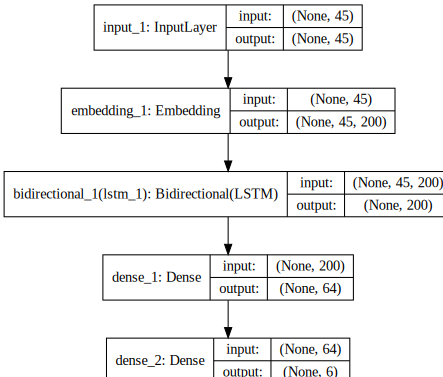

In [31]:
SVG(model_to_dot(nn_model, show_shapes=True, dpi=70).create(prog='dot', format='svg'))

### Train the model

In [32]:
import time

In [33]:
start_time = time.time()

history = nn_model.fit(train_padded_sequences, 
                       train_labels, 
                       validation_split=0.1, 
                       epochs=10)

elapsed_time = time.time() - start_time
t = time.strftime("%H:%M:%S", time.gmtime(elapsed_time))
print('Elapsed time (learning):', t)


Train on 86 samples, validate on 10 samples
Epoch 1/10
86/86 [==============================] - 2s 22ms/step - loss: 1.7076 - accuracy: 0.2791 - val_loss: 1.5671 - val_accuracy: 0.6000
Epoch 2/10
86/86 [==============================] - 0s 4ms/step - loss: 1.3726 - accuracy: 0.8023 - val_loss: 1.3355 - val_accuracy: 0.8000
Epoch 3/10
86/86 [==============================] - 0s 4ms/step - loss: 1.0649 - accuracy: 0.9070 - val_loss: 1.0587 - val_accuracy: 0.8000
Epoch 4/10
86/86 [==============================] - 0s 4ms/step - loss: 0.7578 - accuracy: 0.9651 - val_loss: 0.7331 - val_accuracy: 0.9000
Epoch 5/10
86/86 [==============================] - 0s 4ms/step - loss: 0.4779 - accuracy: 0.9884 - val_loss: 0.4403 - val_accuracy: 1.0000
Epoch 6/10
86/86 [==============================] - 1s 7ms/step - loss: 0.2783 - accuracy: 1.0000 - val_loss: 0.2815 - val_accuracy: 1.0000
Epoch 7/10
86/86 [==============================] - 0s 4ms/step - loss: 0.1506 - accuracy: 1.0000 - val_loss: 0.16

### Plot loss and accuracy

In [34]:
history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

In [35]:
import matplotlib.pyplot as plt

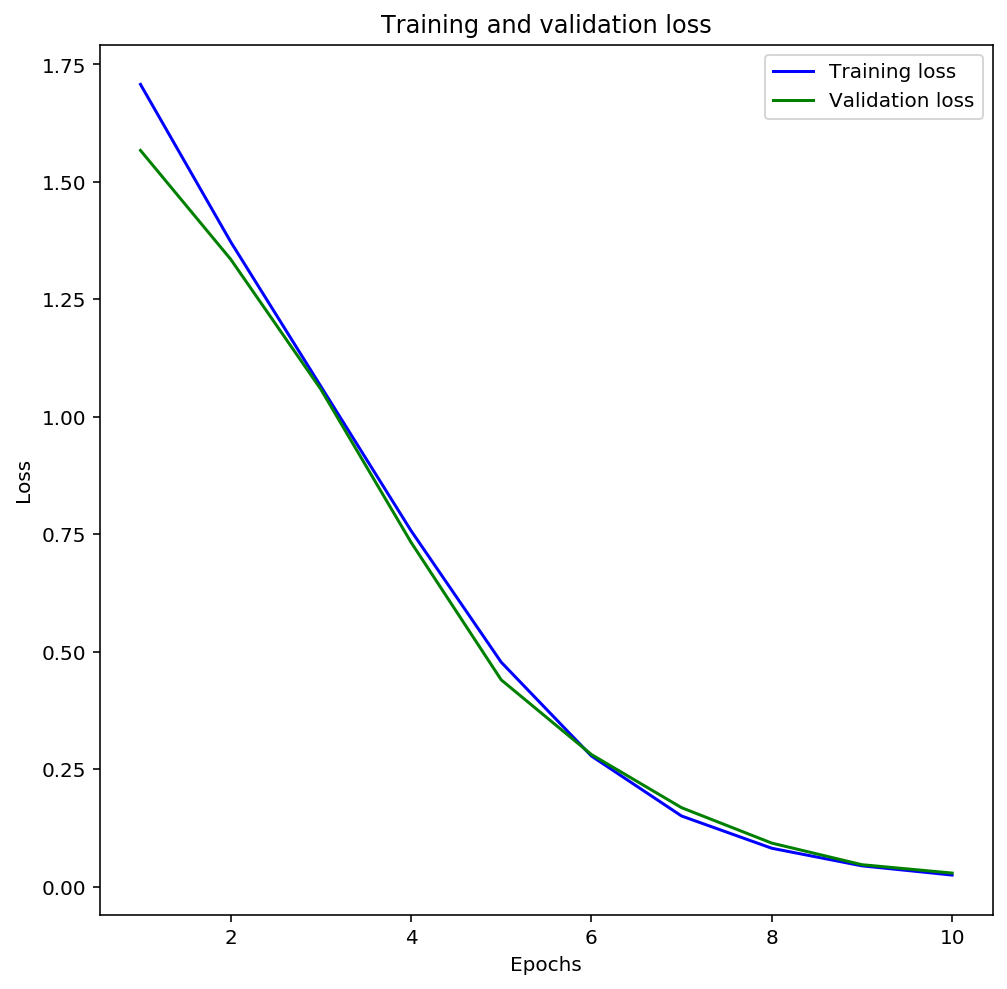

In [36]:
plt.figure(figsize=(8,8))
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'g', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

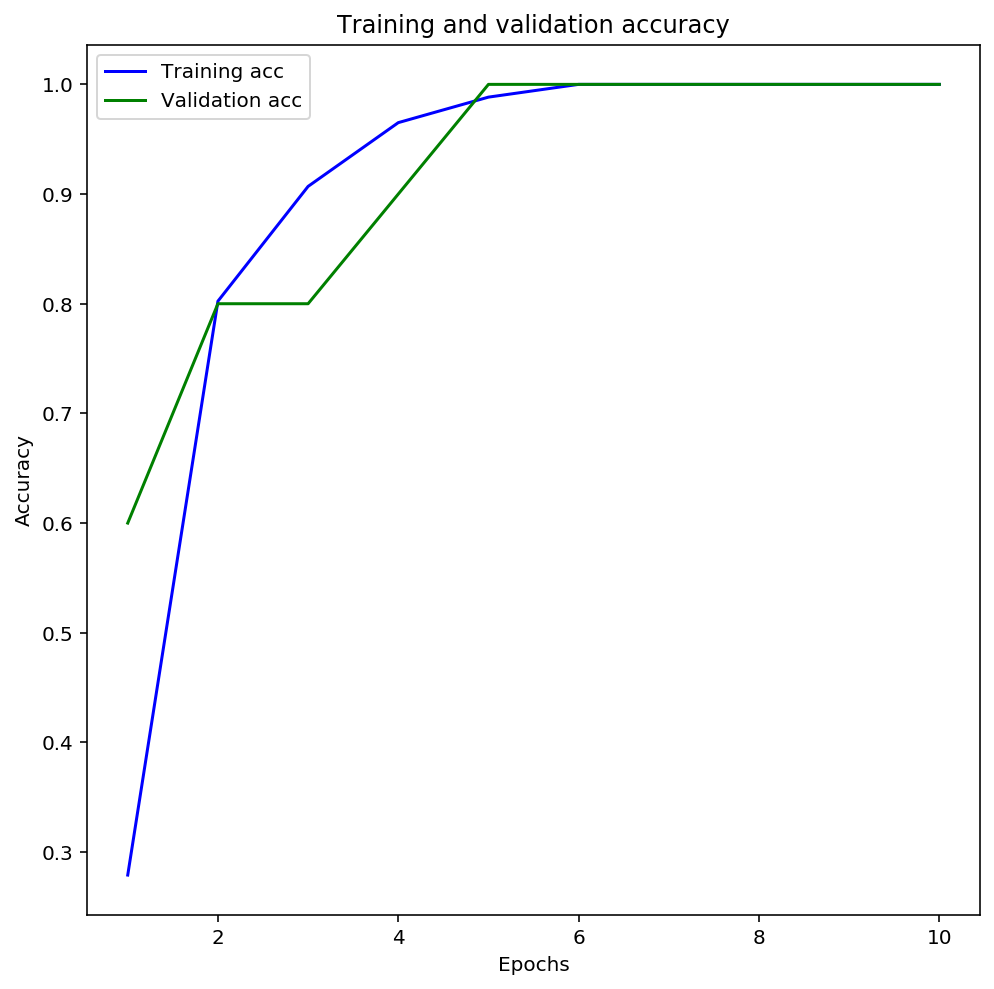

In [37]:
plt.figure(figsize=(8,8))
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'g', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

---

## Evaluate the model

### Compute f-score on the test set

In [38]:
test_sequences = [doc_tokens_to_sequence(corpus.get_tokens(doc_id), word_to_idx_map) for doc_id in test_doc_ids]
test_padded_sequences = pad_sequences(test_sequences, maxlen=max_doc_len)

In [39]:
test_pred = nn_model.predict(test_padded_sequences)

In [40]:
# round to nearest integer
test_pred = np.rint(test_pred)

In [41]:
test_pred[0]

array([0., 0., 0., 0., 1., 0.], dtype=float32)

In [42]:
from sklearn.metrics import classification_report

In [43]:
print(classification_report(test_labels, test_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       0.00      0.00      0.00         0
           2       1.00      1.00      1.00         6
           3       1.00      0.83      0.91         6
           4       1.00      1.00      1.00         8
           5       1.00      1.00      1.00         1

   micro avg       1.00      0.96      0.98        24
   macro avg       0.83      0.81      0.82        24
weighted avg       1.00      0.96      0.98        24
 samples avg       0.96      0.96      0.96        24



/Users/jgmathew/miniconda3/envs/iml/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jgmathew/miniconda3/envs/iml/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jgmathew/miniconda3/envs/iml/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Save model to a file

In [44]:
nn_filename = f'wikidata_nn_model_{version}.h5'
nn_filepath = os.path.join(root_dir, models_dir, nn_filename)

In [45]:
nn_model.save(nn_filepath)

---

## Save `word_to_index_map` to a file

In [46]:
import pandas as pd

In [47]:
word_to_index_df = pd.DataFrame(word_to_idx_map.items(), columns=['term', 'index'])

In [48]:
word_to_index_df.head()

,term,index
0,+23,1
1,+8,2
2,1,3
3,"1,439",4
4,"10,051",5


In [49]:
word_to_index_df.shape

(239, 2)

In [50]:
index_filename = f'wikidata_nn_word_index_{version}.csv'
index_filepath = os.path.join(root_dir, models_dir, index_filename)

In [51]:
word_to_index_df.to_csv(index_filepath, encoding='utf-8', index=False)

---